In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns


In [48]:

# Load the dataset
file_path = "datasetupdated.csv"  # Change this if the file is in a different location
df = pd.read_csv(file_path)


In [49]:

# Load Data
yearly_cases = df.groupby("YEAR")["CasesReported"].sum().reset_index()



In [50]:

# Convert 'YEAR' to datetime for Prophet
yearly_cases["ds"] = pd.to_datetime(yearly_cases["YEAR"], format="%Y")
yearly_cases["y"] = yearly_cases["CasesReported"]



In [51]:
# -------------------- ARIMA Model --------------------
arima_order = (3, 2, 1)  # Tune if needed
arima_model = ARIMA(yearly_cases["y"], order=arima_order)
arima_fit = arima_model.fit()

# Forecast future 5 years
arima_forecast = arima_fit.forecast(steps=5)

# ✅ Corrected Future Years Alignment
future_years = pd.date_range(start=yearly_cases["ds"].max() + pd.DateOffset(years=-1), periods=5, freq="YE")
arima_df = pd.DataFrame({"ds": future_years, "yhat_arima": arima_forecast})



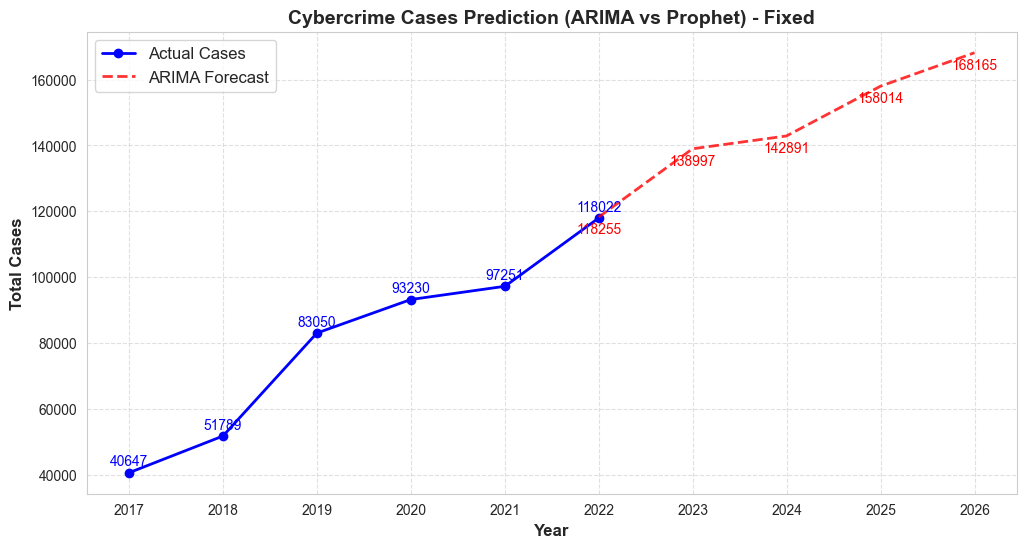

In [52]:


# Set Seaborn theme for better aesthetics
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 6))

# Plot actual cases
plt.plot(yearly_cases["ds"], yearly_cases["y"], 'o-', color="blue", label="Actual Cases", markersize=6, linewidth=2)

# Plot ARIMA forecast with confidence intervals if available
plt.plot(arima_df["ds"], arima_df["yhat_arima"], 'r--', label="ARIMA Forecast", linewidth=2, alpha=0.8)

# Annotate actual cases with values
for i in range(len(yearly_cases)):
    plt.annotate(f"{yearly_cases['y'][i]}", 
                 (yearly_cases["ds"][i], yearly_cases["y"][i]), 
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color="blue")

# Annotate ARIMA forecast values using iloc for correct indexing
for i in range(len(arima_df)):
    plt.annotate(f"{arima_df['yhat_arima'].iloc[i]:.0f}", 
                 (arima_df["ds"].iloc[i], arima_df["yhat_arima"].iloc[i]), 
                 textcoords="offset points", xytext=(0, -12), ha='center', fontsize=10, color="red")

# Labels and title
plt.xlabel("Year", fontsize=12, fontweight='bold')
plt.ylabel("Total Cases", fontsize=12, fontweight='bold')
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet) - Fixed", fontsize=14, fontweight='bold')

# Display legend
plt.legend(fontsize=12)

# Show grid with subtle styling
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [53]:
# -------------------- Prophet Model --------------------
prophet_model = Prophet()
prophet_model.fit(yearly_cases[["ds", "y"]])

# Future Predictions
future = prophet_model.make_future_dataframe(periods=5, freq="YE")
prophet_forecast = prophet_model.predict(future)


16:49:50 - cmdstanpy - INFO - Chain [1] start processing
16:49:50 - cmdstanpy - INFO - Chain [1] done processing


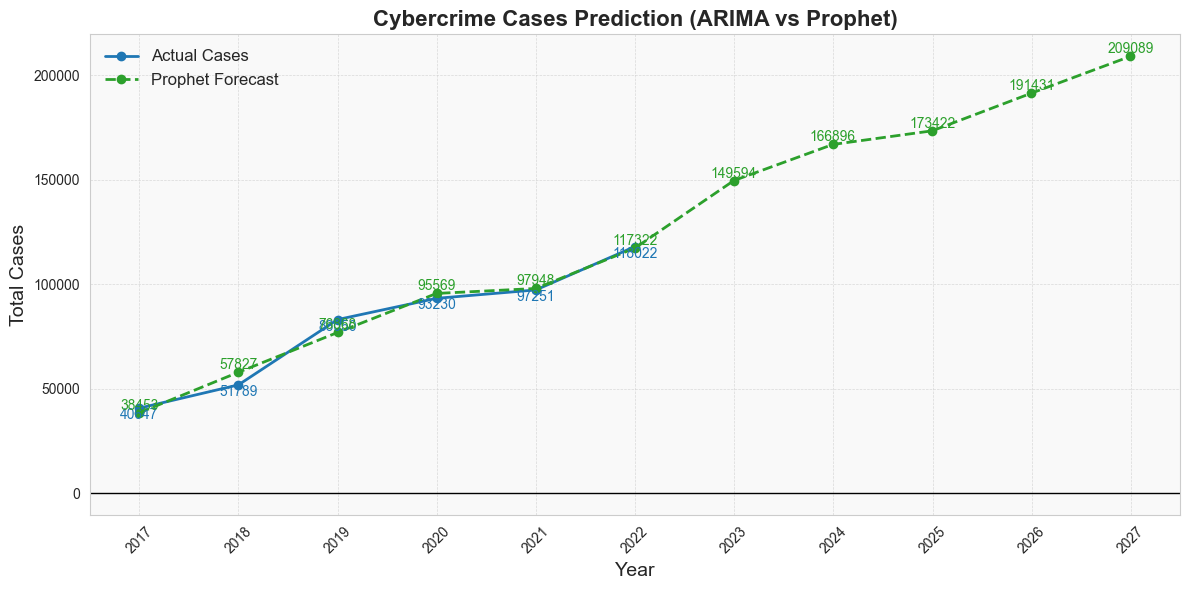

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'yearly_cases' and 'prophet_forecast' are already defined and available

plt.figure(figsize=(12, 6))

# Plot actual cases
plt.plot(yearly_cases["ds"], yearly_cases["y"], 'o-', label="Actual Cases", color='tab:blue', markersize=6, linewidth=2)

# Plot Prophet forecast
plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], 'o--', label="Prophet Forecast", color='tab:green',markersize=6,  linewidth=2)

# Add details to the graph
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Cases", fontsize=14)
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet)", fontsize=16, fontweight='bold')

# Date formatting on x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)

# Adding gridlines and background color
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Adding legend with custom position
plt.legend(loc='upper left', fontsize=12, frameon=False)



# Adding a horizontal line for reference at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Annotate values for the actual cases (alternating above and below)
for i, value in enumerate(yearly_cases["y"]):
        plt.text(yearly_cases["ds"].iloc[i], value, f'{value}', fontsize=10, color='tab:blue', ha='center', va='top')
       

# Annotate values for the Prophet forecast (alternating above and below)
for i, value in enumerate(prophet_forecast["yhat"]):
        plt.text(prophet_forecast["ds"].iloc[i], value, f'{int(value)}', fontsize=10, color='tab:green', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [54]:

# -------------------- Model Evaluation --------------------
# Extract last few known values for error calculation
actual_values = yearly_cases["y"].iloc[-5:].values

# Extract ARIMA & Prophet predictions for the same known period
arima_pred_values = arima_fit.predict(start=len(yearly_cases)-5, end=len(yearly_cases)-1).values
prophet_pred_values = prophet_forecast["yhat"].iloc[-5:].values

# Calculate MAE and RMSE
arima_mae = mean_absolute_error(actual_values, arima_pred_values)
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_pred_values))

prophet_mae = mean_absolute_error(actual_values, prophet_pred_values)
prophet_rmse = np.sqrt(mean_squared_error(actual_values, prophet_pred_values))

# Print Error Metrics
print(f"ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")
print(f"Prophet MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}")


ARIMA MAE: 7365.72, RMSE: 8660.84
Prophet MAE: 89418.35, RMSE: 89655.01


C:\Users\sampu\AppData\Local\Temp\ipykernel_21124\1101803237.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(arima_df["ds"], arima_df["yhat_arima"], 'r--', label="ARIMA Forecast", color='tab:red', linewidth=2)
C:\Users\sampu\AppData\Local\Temp\ipykernel_21124\1101803237.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], 'g--', label="Prophet Forecast", color='tab:green', linewidth=2)


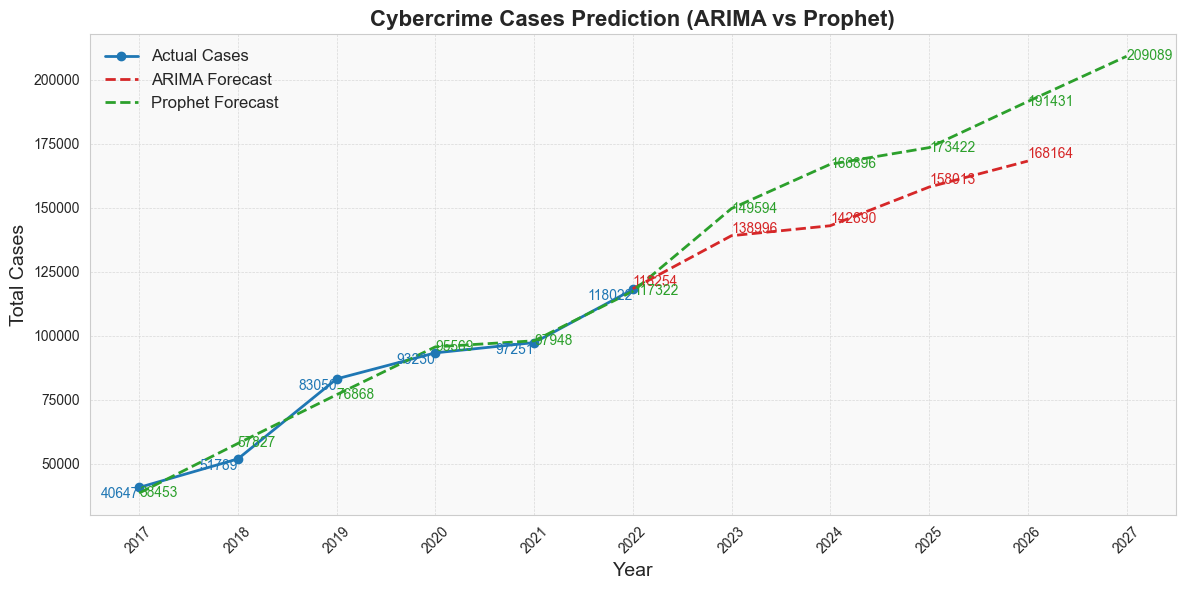

In [79]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'yearly_cases', 'arima_df', and 'prophet_forecast' are already defined

plt.figure(figsize=(12, 6))

# Plot actual cases
plt.plot(yearly_cases["ds"], yearly_cases["y"], 'o-', label="Actual Cases", color='tab:blue', markersize=6, linewidth=2)

# Plot ARIMA forecast
plt.plot(arima_df["ds"], arima_df["yhat_arima"], 'r--', label="ARIMA Forecast", color='tab:red', linewidth=2)

# Plot Prophet forecast
plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], 'g--', label="Prophet Forecast", color='tab:green', linewidth=2)

# Add details to the graph
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Cases", fontsize=14)
plt.title("Cybercrime Cases Prediction (ARIMA vs Prophet)", fontsize=16, fontweight='bold')

# Date formatting on x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)

# Adding gridlines and background color
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Adding legend with custom position
plt.legend(loc='upper left', fontsize=12, frameon=False)

# Annotate values for the actual cases (placing values to the right)
for i, value in enumerate(yearly_cases["y"]):
    plt.text(yearly_cases["ds"].iloc[i], value, f'{value}', fontsize=10, color='tab:blue', ha='right', va='top')

# Annotate values for the ARIMA forecast (placing values to the right)
for i, value in enumerate(arima_df["yhat_arima"]):
    plt.text(arima_df["ds"].iloc[i], value, f'{int(value)}', fontsize=10, color='tab:red', ha='left', va='bottom')

# Annotate values for the Prophet forecast (placing values to the right)
for i, value in enumerate(prophet_forecast["yhat"]):
    plt.text(prophet_forecast["ds"].iloc[i], value, f'{int(value)}', fontsize=10, color='tab:green', ha='left', va='center')

# Show the plot
plt.tight_layout()
plt.show()
